In [1]:
%load_ext autoreload
%autoreload 2

# Rethinking Object Detection as Language Modelling: Lessons from Reimplementing Pix2Seq

*What I learned building Google's radical approach to object detection from scratch - and why it changed how I think about computer vision*

# Why I Rebuilt Pix2Seq from Scratch

A few months ago, I found myself in [yet another object detection discussion](https://medium.com/data-science-at-microsoft/the-windows-of-perception-object-recognition-and-region-proposals-8cf5e66256a9) filled with Feature Pyramid Networks, Region Proposal Networks, and Non-Maximum Suppression blocks. As someone who's spent considerable time in the trenches of various object detection projects, I was struck by a familiar feeling: *this is incredibly complex for what should be a conceptually simple task*.

Then I remembered a paper from Google Research that I'd scanned over but never fully digested: ["Pix2Seq: A Language modelling Framework for Object Detection"](https://arxiv.org/abs/2109.10852). The core premise seemed absurdly simple: what if we just treated object detection like language modelling? No anchors, no NMS, no complex loss functions - just a model that looks at an image and outputs predictions in a structured way.

The Pix2Seq paper introduces a novel approach to object detection, in which:
- Instead of using specialized architectures, it treats detection as a language modelling task and uses a generic encoder-decoder transformer
- Bounding boxes and class labels are expressed as sequences of tokens
- The model learns to generate these sequences auto-regressively

I'll be honest - I was sceptical, but intrigued. I was also curious enough to try rebuilding it from scratch to see what I'd learn; this process genuinely changed how I think about the relationship between computer vision, natural language processing and any form of sequence modelling. Rather than creating a completely faithful reproduction, I wanted to explore how the core ideas would work with modern techniques and my own engineering preferences. 

This post is my attempt to share those learnings - the surprising insights, the elegant solutions, and the moments where I had to step back and appreciate the sheer cleverness of both the original paper and the possibilities it opens up. This isn't intended to be a theoretical deep-dive into transformer architectures or a comprehensive literature review. Instead, I want to share the practical insights I gained from implementing this model.

**Implementation Framework Choice**: While the original Pix2Seq paper used TensorFlow, I chose to implement everything in PyTorch as I much prefer it to TensorFlow; this turned out to be a good decision, as PyTorch's debugging experience is more intuitive when working with complex tokenization and generation logic!

This choice required translating some TensorFlow-specific concepts (like their data pipeline and loss computation) into PyTorch idioms, but the core algorithmic insights from the paper translate seamlessly across frameworks. The mathematical concepts - quantization, sequence augmentation, and constrained generation - are framework-agnostic.

To get the most out of this blog post, I'd strongly recommend reading alongside the accompanying repository; first reading the section, then going to look at the code. Some of the snippets in this blog post are simplified to aid explanation, please look to the repo to find the working implementation, as well as all code required to reproduce the outputs of this blog post.

## The Complexity Crisis in Object Detection

Before diving into Pix2Seq's elegance, it's worth appreciating what we're trying to escape from. If you've worked with object detection before, you'll know that modern systems are marvels of engineering - but they're also monuments to accumulated complexity.

Consider what happens in a typical two-stage detector like [Faster R-CNN](https://arxiv.org/abs/1506.01497):

1. **Feature extraction** through a backbone network
2. **Anchor generation** at multiple scales and aspect ratios
3. **Region Proposal Network** to suggest potential object locations
4. **RoI alignment** to extract fixed-size features
5. **Dual-head prediction** for classification and bounding box regression
6. **Complex loss functions** balancing classification, localization, and objectness
7. **Non-Maximum Suppression** to eliminate duplicate detections

In a [previous blog post](https://medium.com/data-science/yolov7-a-deep-dive-into-the-current-state-of-the-art-for-object-detection-ce3ffedeeaeb?source=friends_link&sk=4281bc61b8197368d1092d8b8d6ffa64), where a colleague and I re-implemented [Yolov7](https://arxiv.org/abs/2207.02696), we spent hours understanding exactly how the loss function worked and our writeup of this spanned pages.

Whilst transformer-based approaches like [DETR](https://arxiv.org/abs/2005.12872) initially seemed promising - eliminating some architectural complexity, and directly predicting sets of objects without anchor generation or NMS - it introduced its own challenges in the form of the [*Hungarian matching algorithm*](https://en.wikipedia.org/wiki/Hungarian_algorithm) for training. During each forward pass, DETR requires solving an assignment problem to optimally match predicted objects with ground truth objects, minimizing a combined loss function that balances classification, localization, and objectness scores. This bipartite matching process, while mathematically elegant, adds significant implementation complexity and can be challenging to debug when training doesn't converge as expected. So whilst DETR represented genuine progress toward more principled object detection, it still required substantial task-specific engineering - just in a different part of the pipeline.

Each component required years of research to perfect. The loss functions alone are works of art - carefully balancing multiple objectives with hand-tuned weights. However, here's the thing that struck me at the time during our implementation journey: *all of this complexity exists because we're fighting against a fundamental mismatch between what we want (a list of objects) and how we're getting it (dense predictions over spatial grids).*

What if we could eliminate this mismatch entirely?

## The Pix2Seq Revolution: Images as Token Sequences

Instead of predicting objects through increasingly complex spatial reasoning, what if we simply taught a model to *read* images and *speak* about what it sees using a structured language? The main insight from the Pix2Seq paper can be distilled down to this - what if we represent images, bounding boxes and labels as a sequence of tokens, and train a model to output these directly.

The transformation is conceptually simple:

**Before (Traditional Detection):**
```
Image → Complex Architecture → Dense Predictions → NMS → Object List
```

**After (Pix2Seq):**
```
Image → Simple Encoder-Decoder → Token Sequence → Object List
```

However, what initially puzzled me was how exactly we convert the continuous, unordered world of bounding boxes into the discrete, ordered world of language? Let's explore how this is done.

## Converting Coordinates to Tokens

The first challenge I encountered was the most fundamental to this entire approach: how do we represent a bounding box, and its associated class, as tokens? This isn't like tokenizing text where natural word boundaries exist. We're dealing with continuous coordinates, that can take on essentially infinite values, that we need to map to discrete symbols.

Let's walk through a concrete example to illustrate this. Consider a bounding box with coordinates `[0.125, 0.333, 0.875, 0.667]` (XYXY format, normalized to the [0,1] range).

The paper's approach is elegantly simple: divide the coordinate space [0,1] into a fixed number of uniform bins, then round each coordinate to its nearest bin. We can implement this as follows:

```python
class TokenProcessor:
    def quantize(self, boxes: torch.Tensor) -> torch.Tensor:
        # Scale coordinates to quantization range [0, bins-1] 
        # and round to nearest integer (the actual quantization step)
        boxes = torch.round(boxes * (self.quantization_bins - 1))
        
        # Clamp to valid range (handle any edge cases)
        boxes = torch.clamp(boxes, 0, self.quantization_bins - 1)
        
        # Shift to coordinate vocabulary range
        boxes = boxes + self.coord_vocab_shift
        return boxes.long()
```


Now, let's trace through a concrete example with 1000 quantization bins:

```python
# Original normalized coordinate
original_coord = 0.125

# Step 1: Scale to [0, 999] range
scaled = 0.125 * (1000 - 1) = 0.125 * 999 = 124.875

# Step 2: Round to nearest integer
quantized = round(124.875) = 125

# Step 3: Add vocabulary shift (e.g., coord_vocab_shift = 1000)
token = 125 + 1000 = 1125
```

So the continuous coordinate `0.125` becomes the discrete token `1125`.

The quantization precision depends on the number of bins relative to the image resolution. Let's analyse this:

In [6]:
def analyze_quantization_precision(image_size=640, quantization_bins=1000):
    """Calculate the precision of coordinate quantization."""
    
    # Pixels per quantization bin
    pixels_per_bin = image_size / quantization_bins
    print(f"Pixels per bin: {pixels_per_bin:.2f}")
    
    # Maximum quantization error (in pixels)
    max_error_pixels = pixels_per_bin / 2
    print(f"Max quantization error: {max_error_pixels:.2f} pixels")
    
    # As percentage of image size
    error_percentage = (max_error_pixels / image_size) * 100
    print(f"Max error as % of image: {error_percentage:.3f}%")


In [10]:
analyze_quantization_precision(image_size=640, quantization_bins=1000)

Pixels per bin: 0.64
Max quantization error: 0.32 pixels
Max error as % of image: 0.050%


With 1000 bins on a 640×640 image, we get sub-pixel precision! The paper shows that even 500 bins (1.28 pixels per bin) work well in practice.

During inference, we need to convert tokens back to coordinates:

```python
class TokenProcessor:
    def dequantize(self, tokens: torch.Tensor) -> torch.Tensor:
        # Remove coordinate vocabulary shift
        tokens = tokens - self.coord_vocab_shift
        # Scale back to [0, 1] range
        tokens = torch.clamp(tokens, 0, self.quantization_bins - 1)
        # Convert back to [0,1] normalized coordinates
        return tokens.float() / (self.quantization_bins - 1)

```

**Example dequantization:**
```python
# Token from model output
token = 1125

# Remove vocabulary shift
quantized = 1125 - 1000 = 125

# Convert to normalized coordinate
normalized = 125 / (1000 - 1) = 125 / 999 = 0.1251
```

The slight difference of approximately `0.0001` from our original value of `0.125` is the quantization error introduced by this process.

This quantization scheme is simple but remarkably effective. It transforms the infinite space of possible bounding boxes into a discrete, learnable vocabulary while maintaining the precision needed for accurate object detection. Now, let's look at how we can define our vocabulary of tokens.

The effect of different levels of quantization on the placement of bounding boxes is illustrated below. In this case, the image is of size 480x640.

![quantization_image](./images/quantization_image.png)

Image src: pix2seq paper

### Defining our Vocabulary

The vocabulary design is another area where Pix2Seq's elegance truly shines due to its intentional structure. In the original paper, the reserved ranges used by the authors for special tokens, classes, and coordinate tokens which were fixed regardless of use case. This was to enable flexibility when extending the approach to multiple datasets or tasks. In my implementation, to minimise the number of unused tokens, I fixed explicit special tokens and made the rest of the vocabulary dynamic based on the number of classes and the number of quantization bin. In my opinion, this makes the model easier to reason about and debug, but means that additional thought is needed if the model is finetuned downstream to make sure that the classes map appropriately.

I defined the model's vocabulary in the following way:

```python
# Reserved 10 tokens for special tokens by default
num_special_tokens = 10
BASE_VOCAB_SHIFT = num_special_tokens

# Special tokens
PADDING_TOKEN = 0    # For variable-length sequences
BOS_TOKEN = 1        # Beginning of sequence
EOS_TOKEN = 2        # End of sequence

# Class tokens (e.g., 10-89 for 80 COCO classes)
class_range = range(BASE_VOCAB_SHIFT, BASE_VOCAB_SHIFT + num_classes)

# Fake class token for data augmentation boxes
FAKE_CLASS_TOKEN = BASE_VOCAB_SHIFT + num_classes
coord_vocab_shift = FAKE_CLASS_TOKEN + 1

# Coordinate tokens (e.g., 91-1090 for 1000 bins)
coord_range = range(coord_vocab_shift, coord_vocab_shift + quantization_bins)
```

Notice that whilst the quantization choice directly affects the model's vocabulary size:

```python
# Vocabulary breakdown for COCO (80 classes, 1000 bins)
special_tokens = 10          # BOS, EOS, PAD, etc.
class_tokens = 80            # One per COCO class  
fake_class_token = 1         # For sequence augmentation
coordinate_tokens = 1000     # Quantization bins

total_vocab_size = special_tokens + class_tokens + fake_class_token + coordinate_tokens
# = 10 + 80 + 1 + 1000 = 1091 tokens
```

Even when we are achieving sub-pixel precision, this is remarkably small compared to modern language models; even GPT-3 uses 50,000+ tokens. This leaves us plenty of room to scale the number of quantization bins if we would like to train on larger images.



At this point, you may be wondering what exactly the `FAKE_CLASS_TOKEN` is used for - we shall cover that when we discuss data augmentation.


### Sequence Construction

Now that we have a vocabulary, the next challenge is converting sets of objects into sequences. Unlike text, objects in an image don't have a natural ordering, the ordering of boxes shouldn't matter. The solution I implemented follows the paper's approach: each object becomes a 5-token sequence `[y_min, x_min, y_max, x_max, class]`, and multiple objects are simply concatenated. During training, the annotations are ordered randomly.

Like many other papers from Google, the paper uses `y_min` as the first coordinate, not `x_min` as would usually be expected. I prefer to follow standard conventions and use the `[x_min, y_min, x_max, y_max, class]` consistently throughout my codebases, so I ensured that this conversion only happened as part of encoding and decoding in the tokenizer.

A simplified version of this logic is presented below: 

```python
class TokenProcessor:
    def build_sequences(self, boxes: torch.Tensor, labels: torch.Tensor):
        """Convert bounding boxes to token sequences."""
        batch_size, num_boxes = boxes.shape[:2]
        
        # Convert XYXY to YXYX format (paper's convention)
        boxes = boxes[..., [1, 0, 3, 2]]
        
        # Quantize coordinates to discrete tokens
        boxes = self.quantize(boxes)  # [B,N,4]
        
        # Add vocabulary shift to class labels
        target_labels = labels + self.BASE_VOCAB_SHIFT
        
        # Create 5-token sequences for each object
        target_seq = torch.cat([boxes, target_labels.unsqueeze(-1)], dim=-1)
        
        # Flatten to single sequence per image
        target_seq = target_seq.reshape(batch_size, -1)
        
        # Add sequence boundary tokens
        target_seq = self._add_boundary_tokens(target_seq)
        
        return target_seq
```

The logic in the codebase also handles aspects such as including padding tokens and ensuring correct bounding box ranges, which I have omitted here for clarity.

The beauty of this representation is that it transforms the complex problem of "find all objects" into the familiar problem of "generate the next token." Every technique from language modelling - attention mechanisms, teacher forcing, KV-caching - suddenly becomes applicable to object detection.


## Data Augmentation

At this point, the benefits of data augmentation are well understood when training deep learning models; increasing training data variety to improve robustness, without collecting additional real-world samples. However, as Pix2Seq is an autoregressive model - generating sequences token by token - this adds some additional considerations for our augmentation strategy.

Autoregressive transformer models are usually trained using an approach called teacher forcing - providing the correct previous tokens as input during training to enable parallel computation and prevent error accumulation, making transformer training faster and more stable - and Pix2Seq is no different. During training with teacher forcing, the model only sees perfect ground-truth sequences. But during inference, it must generate sequences step by step, potentially making errors early on that compound throughout generation.

This creates what's known as *exposure bias* - the model is never trained to recover from its own mistakes. In object detection, this manifests as:

- **Early termination**: The model stops generating before finding all objects
- **Poor duplicate handling**: The model generates redundant detections
- **Cascading errors**: One wrong coordinate prediction throws off the entire box

Therefore, in addition to the commonly used approaches that we would expect to observe in object detection, we must also consider *sequence augmentation*; teaching the model to handle imperfect, noisy sequences during training - making them far more robust when generating predictions on their own.


The approach to data augmentation taken by Pix2Seq can be summarised into three broad categories:
- Image augmentation: 
- box augmentation
- sequence augmentation

Let's explore these in turn.

In [2]:
import matplotlib.pyplot as plt
import torch

from data.base_dataset import COCOBaseDataset
from data.augmentations import ImageAugmentor, BBoxAugmentation
from plotting import show_image_with_boxes, visualize_augmentations

coco_images_path = "/workspaces/object-detection-rl/data/coco/images/val2017"
coco_annotations_path = (
    "/workspaces/object-detection-rl/data/coco/annotations/instances_val2017.json"
)

ds = COCOBaseDataset(coco_images_path, coco_annotations_path, filter_crowd=True)
category_names = ds.get_categories()

image_idx = 62
image, xyxy_bboxes, class_ids, image_id, image_hw = ds[image_idx]

/opt/conda/envs/core/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/core/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


### Image augmentation

Whilst not really discussed in the paper, inspecting the code revealed that the approach to image augmentation was quite standard; sophisticated techniques like Mixup and Mosaic were not used. Rather than trying to exactly replicate the hyperparameters used by the authors, I created an image augmentation pipeline following the core ideas of their approach of flipping, scale jittering, cropping and colour augmentation.

Some examples of the image augmentations used can be seen below:

In [8]:
train_augmentor = ImageAugmentor(
    image_size=640,
    jitter_scale=(0.3, 2.0),
    color_jitter_strength=0.4,
    training=True,
    enable_replay=True,
)

eval_augmentor = ImageAugmentor(image_size=640, training=False, enable_replay=True)

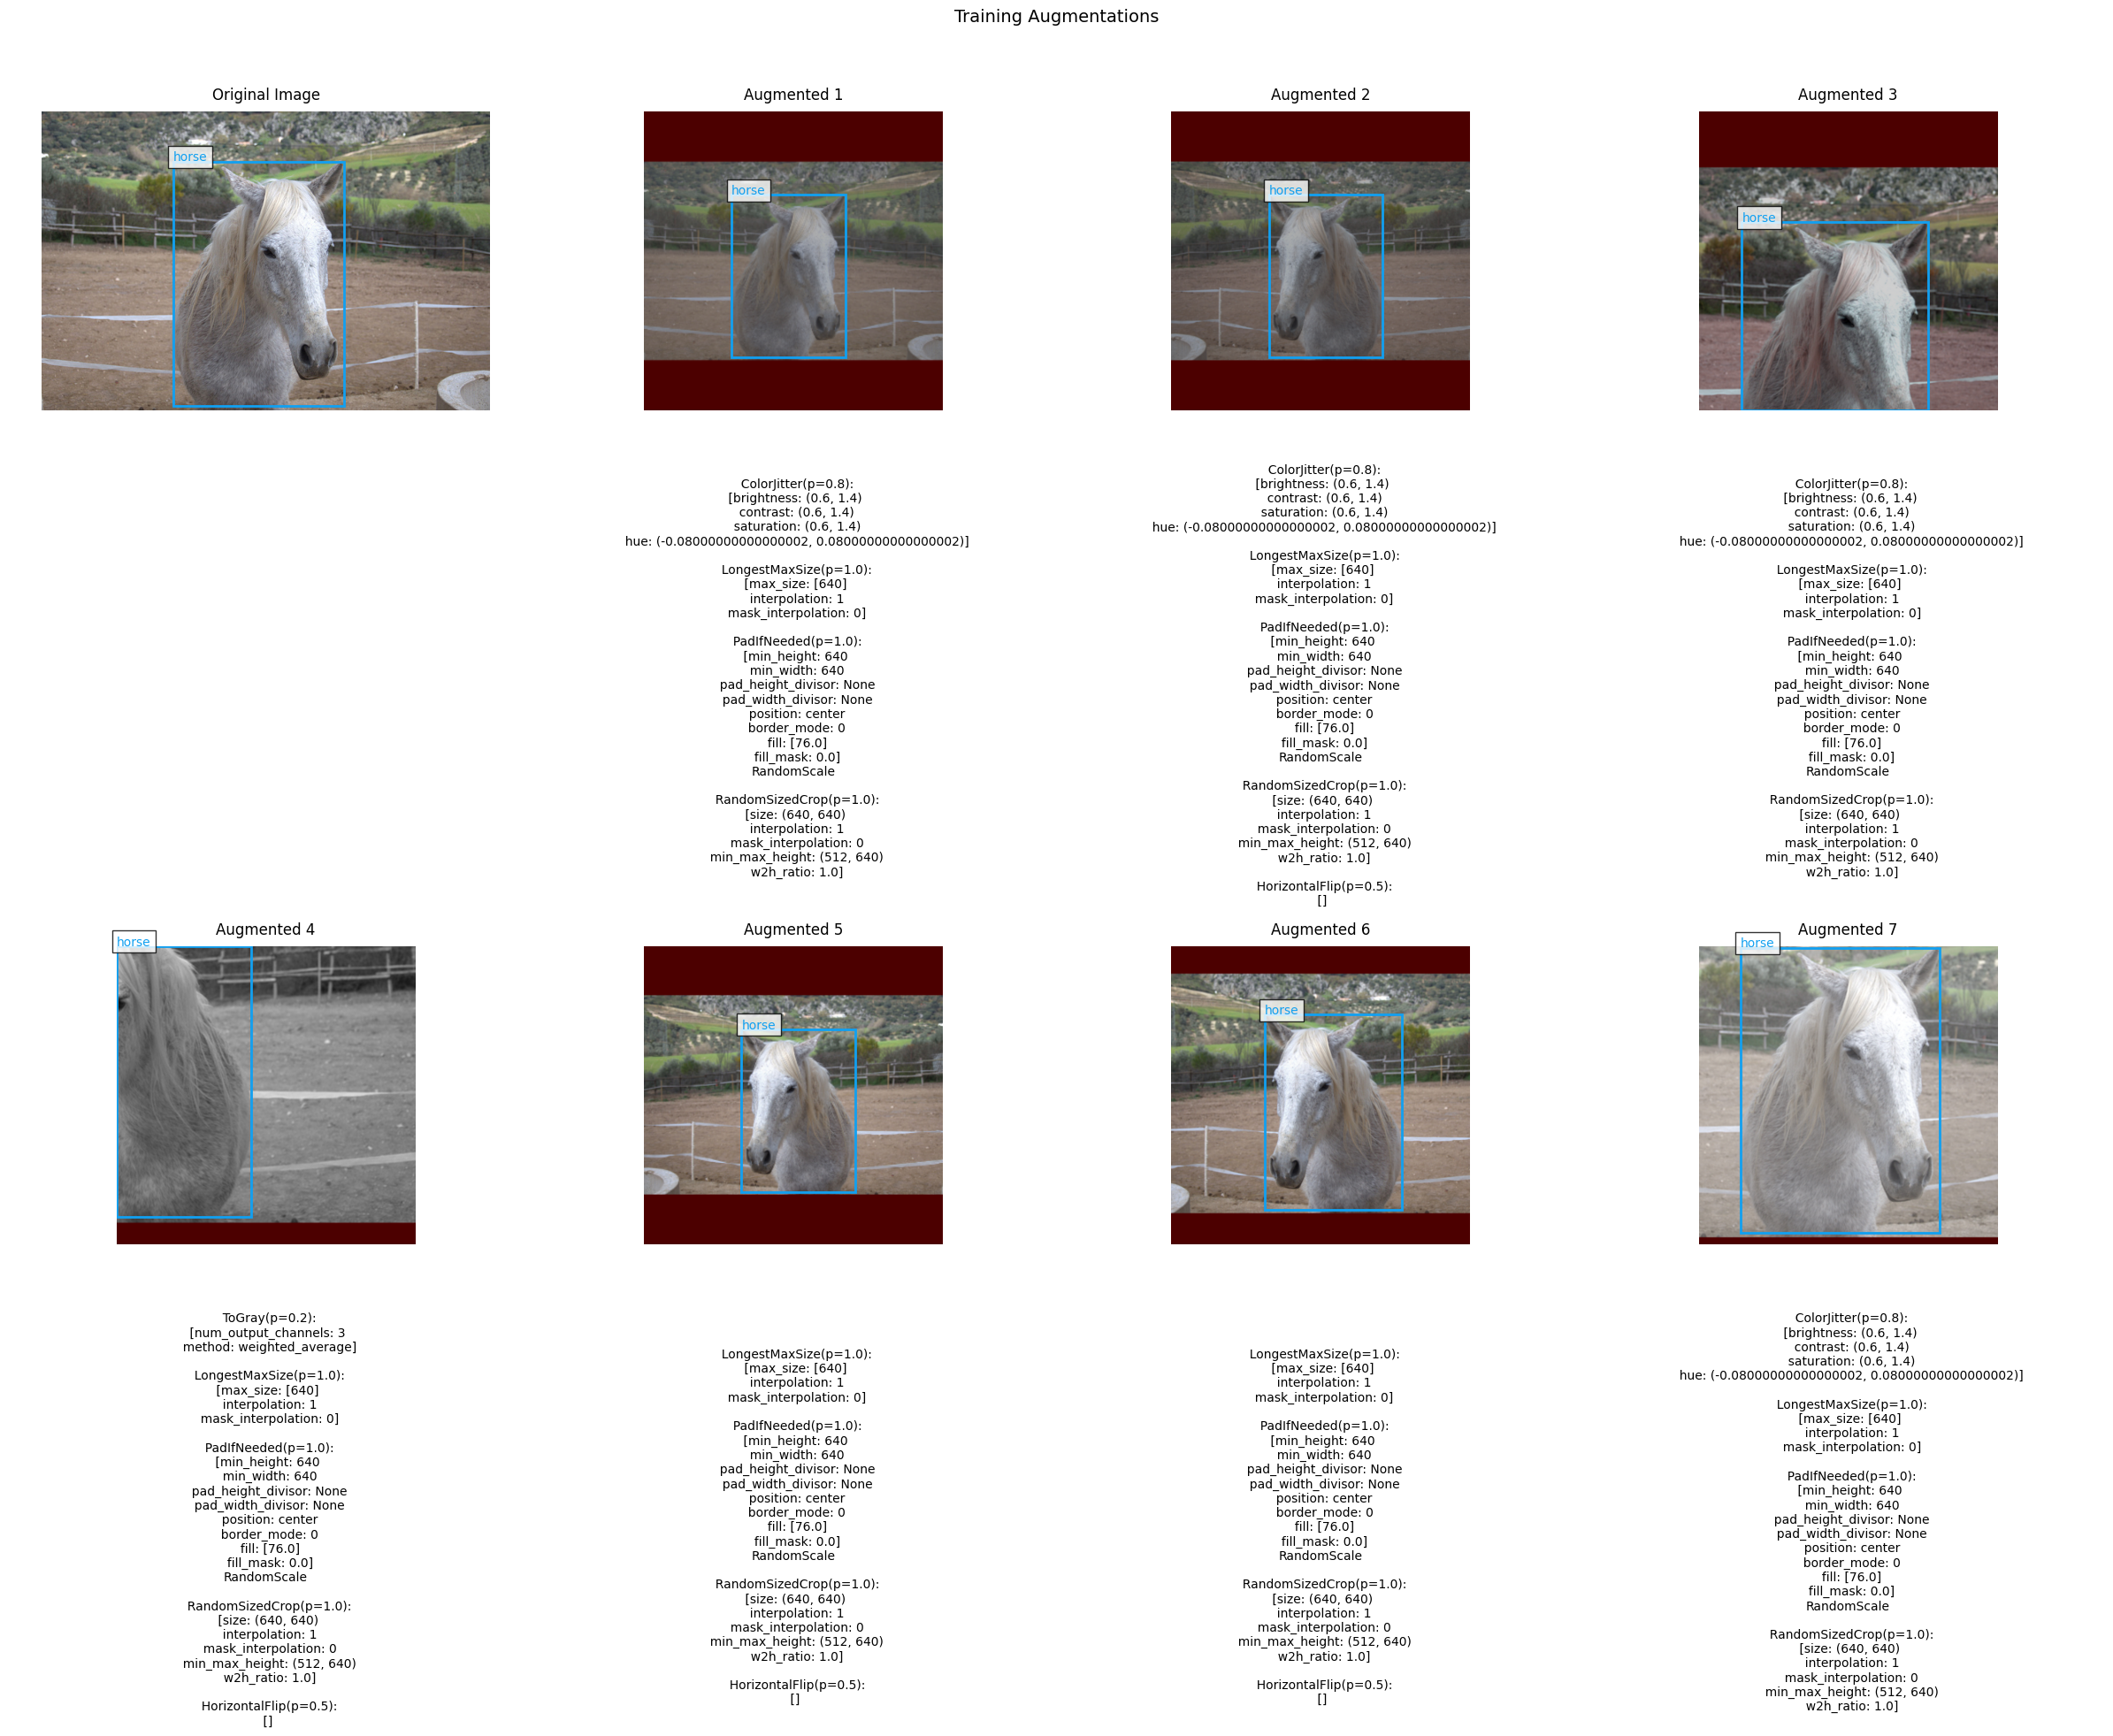

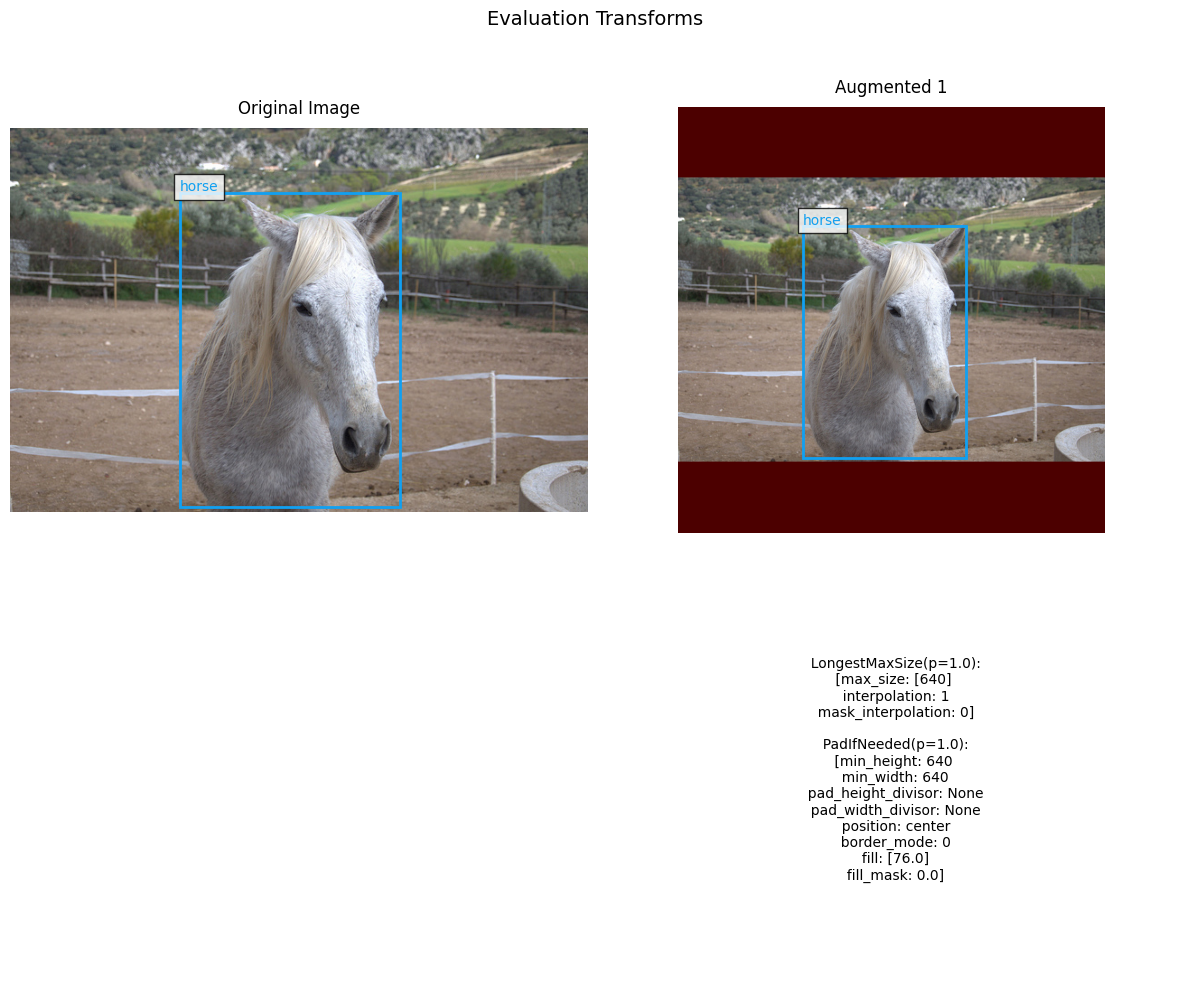

In [ ]:


# Show training augmentations
fig1 = visualize_augmentations(
    image, xyxy_bboxes, class_ids, train_augmentor, category_names, num_examples=7
)
fig1.suptitle("Training Augmentations", size=14)

# Show eval augmentations
fig2 = visualize_augmentations(
    image, xyxy_bboxes, class_ids, eval_augmentor, category_names, num_examples=1
)
fig2.suptitle("Evaluation Transforms", size=14)
plt.show()

## Box Augmentation

Whilst the approach to image augmentation was fairly standard, the approach to box augmentation is where things start to get interesting. Before we dive into the specific augmentations, let's first remind ourselves of the motivation behind they are needed.

Object detection models need to be robust to various challenges:
1. Small variations in object localization
2. False positive detections
3. Overlapping and duplicate detections

Therefore, we would like to teach our model:

1. **Accurate Localization**: Predict box coordinates precisely
2. **Correct Classification**: Identify object categories correctly
3. **False Positive Rejection**: Avoid detecting objects that aren't there
4. **Duplicate Suppression**: Avoid multiple detections of the same object

Pix2Seq addresses these challenges through a comprehensive box augmentation strategy that creates both positive and negative training examples.

Now, let's explore the specific augmentations used.

In [18]:
image, boxes, class_ids, _ = eval_augmentor(image, xyxy_bboxes, class_ids)
augmentor = BBoxAugmentation(num_classes=80)

BBoxAugmentation initialized with:
  - num_classes: 80
  - Will generate fake labels as: 80


### Box Jittering

Box jittering adds small random perturbations to existing boxes to help the model become robust to minor localization variations:

- Creates slight variations of real objects
- Teaches model to be robust to small coordinate differences
- Maintains original class labels since these are valid examples

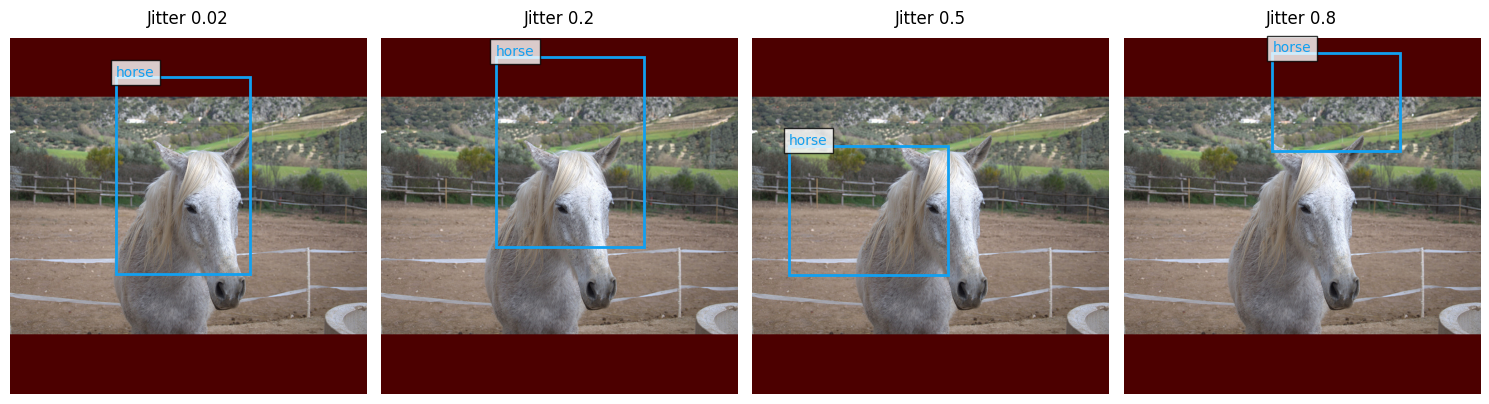

In [ ]:
def visualize_jittering(image, boxes, class_ids, category_names, augmentor):

    # Apply jittering with different strengths
    jitter_amounts = [0.02, 0.2, 0.5, 0.8]
    fig, axes = plt.subplots(1, len(jitter_amounts), figsize=(15, 5))

    for ax, amount in zip(axes, jitter_amounts):
        jittered_boxes = augmentor.jitter_bbox(torch.tensor(boxes), max_range=amount)
        show_image_with_boxes(
            image,
            jittered_boxes,
            class_ids,  # Same labels - these are positive examples
            title=f"Jitter {amount}",
            category_names=category_names,
            ax=ax,
            normalized_boxes=True,
        )
    plt.tight_layout()
    plt.show()


visualize_jittering(image, boxes, class_ids, category_names, augmentor)

Here, I've used extreme values to illustrate the effect; the codebase samples from a truncated normal distribution to keep changes small and realistic. Of course, this should be set based on the variations that you are likely to observe in your domain!

### Shifted Real Boxes to create hard negatives
Box shifting moves boxes to new locations while preserving their size. This helps the model learn to avoid false positives in incorrect locations:

- Takes real object shapes but moves them to wrong locations
- Creates plausible but incorrect detections
- Helps model learn spatial context
- Marked with fake class token to indicate "not a valid detection"

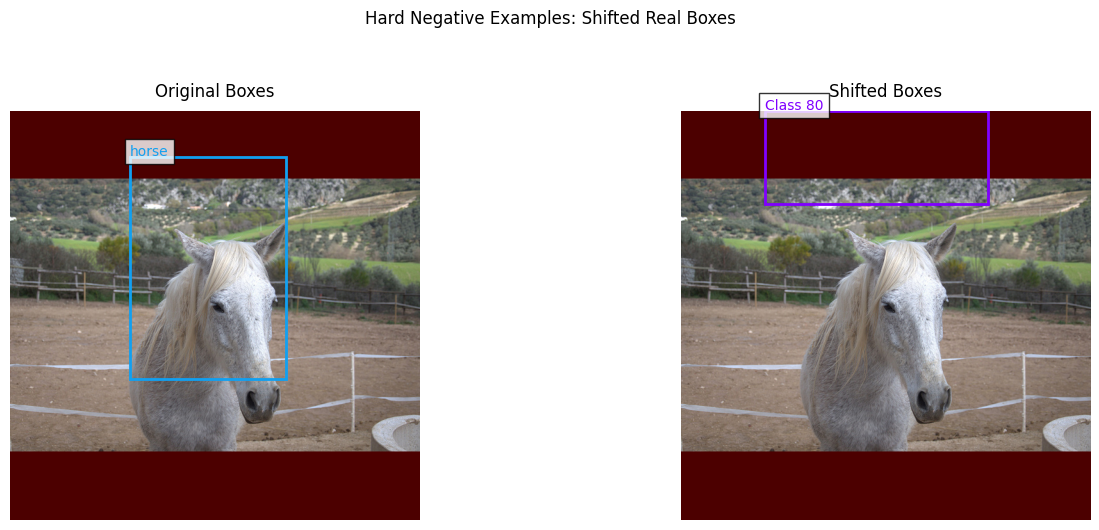

In [28]:
def visualize_shifting(image, boxes, class_ids, categories, augmentor):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Original
    show_image_with_boxes(
        image,
        boxes,
        class_ids,
        title="Original Boxes",
        category_names=categories,
        ax=ax1,
        normalized_boxes=True,
    )

    # Shifted
    shifted_boxes = augmentor.shift_bbox(torch.tensor(boxes))
    fake_labels = torch.full_like(torch.tensor(class_ids), 80)  # FAKE_CLASS_TOKEN

    show_image_with_boxes(
        image,
        shifted_boxes,
        fake_labels,
        title="Shifted Boxes",
        category_names=categories,
        ax=ax2,
        normalized_boxes=True,
    )

    plt.suptitle("Hard Negative Examples: Shifted Real Boxes", y=1.05)
    plt.tight_layout()
    plt.show()


visualize_shifting(image, boxes, class_ids, category_names, augmentor)

### Random Box Generation

Generating completely random boxes helps the model learn to reject arbitrary box proposals:
- Creates diverse negative examples
- Helps model learn to reject arbitrary box proposals
- Marked with fake class token
- Uses normal distribution for sizes to create variety

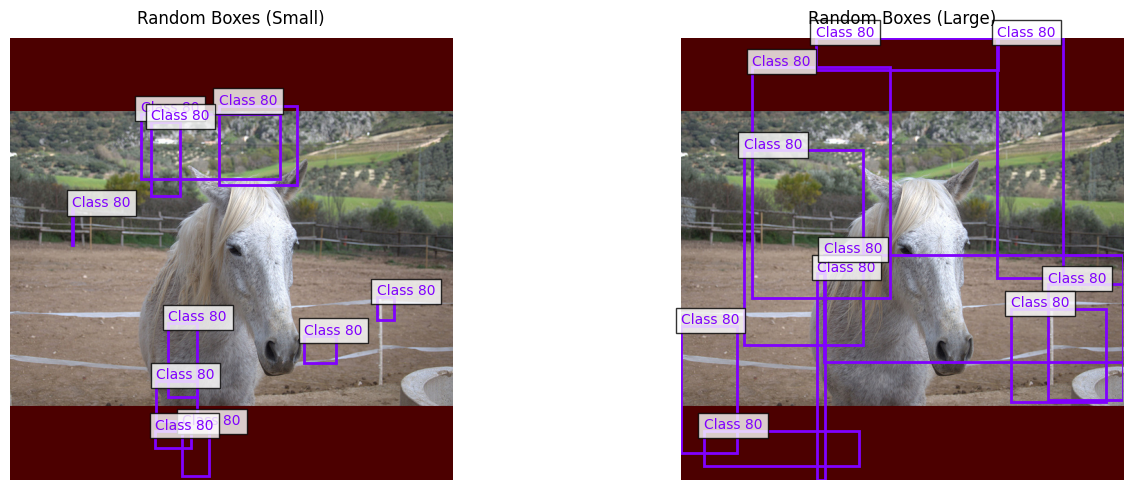

In [29]:
def visualize_random_boxes(image, augmentor, n_boxes=10, ):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Generate two sets of random boxes with different size limits
    random_boxes1, random_labels1 = augmentor.random_bbox(
        n_boxes, max_size=0.3, return_labels=True
    )
    random_boxes2, random_labels2 = augmentor.random_bbox(
        n_boxes, max_size=0.7, return_labels=True
    )

    show_image_with_boxes(
        image,
        random_boxes1,
        random_labels1,
        title="Random Boxes (Small)",
        ax=ax1,
        normalized_boxes=True,
    )

    show_image_with_boxes(
        image,
        random_boxes2,
        random_labels2,
        title="Random Boxes (Large)",
        ax=ax2,
        normalized_boxes=True,
    )

    plt.tight_layout()
    plt.show()


visualize_random_boxes(image, augmentor)

## Sequence augmentation

Whilst image and box augmentation address spatial robustness, sequence augmentation tackles the unique challenges of autoregressive generation. This is where Pix2Seq's approach becomes particularly innovative, as it directly addresses the exposure bias problem inherent in teacher forcing.

The sequence augmentation strategy in Pix2Seq operates on three key principles:

* Label Corruption: Intentionally providing wrong class labels during training
* Noise Token Integration: Teaching the model to handle and generate "fake" detections
* Random Ordering: Shuffling the order of objects in sequences


Let's explore each of these in detail:

In [ ]:
from data.tokenizer import TokenProcessor, LabelCorruptionStrategy
from data.dataset import Pix2SeqDataset, Pix2SeqCollator
from torch.utils.data import DataLoader

In [ ]:

pix2seq_ds = Pix2SeqDataset(
    base_dataset=ds,
    num_classes=80,  # COCO classes
    training=True,
    max_num_objects=25,
    image_size=640,
)

token_processor = TokenProcessor(
    quantization_bins=1000,
    noise_bbox_weight=0.5,
    eos_token_weight=0.1,
    max_seq_len=pix2seq_ds.max_instances * 5 + 2,  # 5 tokens per box + EOS + BOS
    num_classes=80,
    corrupt_class_labels=False,
)


BBoxAugmentation initialized with:
  - num_classes: 80
  - Will generate fake labels as: 80

Token Processor initialized with:
  Special tokens: 0-9
    Padding token: 0
    BOS token: 1
    EOS token: 2
  Base vocab shift: 10
  Class tokens: 10-89
  FAKE_CLASS_TOKEN: 90
  Coordinate tokens: 91-1090
  Total vocab size: 1091



### Label Corruption Strategies

The label corruption mechanism operates through a clever two-stage probabilistic process implemented in the `corrupt_class_labels method`. Let's examine the key parts of the code to understand how it works:

```python
class TokenProcessor
    def corrupt_class_labels(
        self, labels: torch.Tensor, padding_mask: torch.Tensor
    ) -> torch.Tensor:
        """Corrupt class labels according to specified strategy.

        For all strategies, we first decide whether to keep original labels (50% probability).
        Then for labels we'll corrupt, we apply the strategy's noise type:
        - NONE: Keep all labels unchanged
        - RANDOM: Replace with random valid classes
        - RANDOM_AND_FAKE: Equal split between random classes and fake token

        Args:
            labels: Class labels [B,N]
            padding_mask: Boolean mask where True indicates padding [B,N]
        """
        # For 'none' strategy or if corruption is disabled, return original labels
        if (
            self._corruption_strategy == LabelCorruptionStrategy.NONE
            or not self._corrupt_class_labels
        ):
            return labels

        batch_size, num_labels = labels.shape
        valid_tokens = ~padding_mask

        # First decide which valid tokens to keep (50% probability)
        keep_mask = (
            torch.rand(batch_size, num_labels, device=labels.device) < 0.5
        ) & valid_tokens

        # Start with original labels
        corrupted = labels.clone()

        # Create random class labels for corruption
        rand_cls = torch.randint(
            self.BASE_VOCAB_SHIFT, self.BASE_VOCAB_SHIFT + self.num_classes, (batch_size, num_labels), device=labels.device
        )

        if self._corruption_strategy == LabelCorruptionStrategy.RANDOM:
            # For tokens we're not keeping, replace with random classes
            corrupted = torch.where(valid_tokens & ~keep_mask, rand_cls, corrupted)

        elif self._corruption_strategy == LabelCorruptionStrategy.RANDOM_AND_FAKE:
            # For tokens we're not keeping, decide between random and fake
            noise_mask = torch.rand(batch_size, num_labels, device=labels.device) < 0.5
            tokens_to_corrupt = valid_tokens & ~keep_mask

            # Apply random classes where noise_mask is True
            corrupted = torch.where(tokens_to_corrupt & noise_mask, rand_cls, corrupted)

            # Apply fake token where noise_mask is False
            fake_cls = torch.full_like(
                labels, self.FAKE_CLASS_TOKEN, device=labels.device
            )
            corrupted = torch.where(
                tokens_to_corrupt & ~noise_mask, fake_cls, corrupted
            )

        return corrupted

```
From this, we can see that the algorithm first randomly decides which 50% of valid objects to leave unchanged. This ensures that the model always sees some correct labels, preventing complete confusion during training. For the remaining 50% of objects, the strategy determines what type of noise to apply:

The strategies that I implemented are:

* `RANDOM`: Replace with random valid class IDs (0-79 for COCO)
* `RANDOM_AND_FAKE`: Split evenly between random classes and the special fake token we defined in our vocab
* `NONE`: Leave all labels unchanged

Let's see how this looks in practice by running our image and labels through a tokenizer several times.

In [ ]:


# Create tokenizers with different corruption strategies
tokenizer_none = TokenProcessor(
    quantization_bins=1000, noise_bbox_weight=1.0, eos_token_weight=1.0,
    max_seq_len=500, num_classes=80, 
    corrupt_class_labels=False,
    corruption_strategy=LabelCorruptionStrategy.NONE,
    verbose=False
)

tokenizer_random = TokenProcessor(
    quantization_bins=1000, noise_bbox_weight=1.0, eos_token_weight=1.0,
    max_seq_len=500, num_classes=80,
    corrupt_class_labels=True,
    corruption_strategy=LabelCorruptionStrategy.RANDOM,
    verbose=False
)

tokenizer_mixed = TokenProcessor(
    quantization_bins=1000, noise_bbox_weight=1.0, eos_token_weight=1.0,
    max_seq_len=500, num_classes=80,
    corrupt_class_labels=True, 
    corruption_strategy=LabelCorruptionStrategy.RANDOM_AND_FAKE,
    verbose=False
)


print(f"Using COCO image {image_id} with {len(class_ids)} objects")
print(f"Object classes: {class_ids}")
print(f"Class names: {[category_names[cid]['name'] for cid in class_ids]}")

# Apply image augmentation to get normalized boxes (as done in the actual pipeline)
augmented_image, augmented_boxes, augmented_labels, unpadded_size = eval_augmentor(
    image, xyxy_bboxes, class_ids, normalize_boxes=True
)

# Convert to tensors
aug_boxes_tensor = torch.tensor(augmented_boxes, dtype=torch.float32).unsqueeze(0)
aug_labels_tensor = torch.tensor(augmented_labels, dtype=torch.long).unsqueeze(0)
# Extract class tokens helper function
def extract_class_tokens(sequence, tokenizer, num_objects):
    class_positions = [5 + i*5 for i in range(num_objects)]
    return [(sequence[0][pos] - tokenizer.BASE_VOCAB_SHIFT).item() for pos in class_positions]

# Show corruption variation across multiple trials
num_trials = 5
print(f"\nCorruption variation across {num_trials} trials:")

corruption_results = []
fake_class_id = tokenizer_mixed.FAKE_CLASS_TOKEN - tokenizer_mixed.BASE_VOCAB_SHIFT


for trial in range(num_trials):
    
    # Generate sequences with different corruption strategies
    input_seq_none, target_seq_none, weights_none = tokenizer_none.build_sequences(aug_boxes_tensor, aug_labels_tensor)
    input_seq_random, target_seq_random, weights_random = tokenizer_random.build_sequences(aug_boxes_tensor, aug_labels_tensor)
    input_seq_mixed, target_seq_mixed, weights_mixed = tokenizer_mixed.build_sequences(aug_boxes_tensor, aug_labels_tensor)
    
    num_objects = len(augmented_labels)
    
    # Extract class tokens
    input_classes_random = extract_class_tokens(input_seq_random, tokenizer_random, num_objects)
    input_classes_mixed = extract_class_tokens(input_seq_mixed, tokenizer_mixed, num_objects)
    target_classes = extract_class_tokens(target_seq_none, tokenizer_none, num_objects)
    
    # Check for changes
    random_changes = [f"{category_names[orig]['name']}→{category_names[new]['name'] if 0 <= new < 80 else 'INVALID'}" 
                     for orig, new in zip(target_classes, input_classes_random) if orig != new]
    
    mixed_changes = [f"{category_names[orig]['name']}→{'FAKE' if new == fake_class_id else category_names[new]['name'] if 0 <= new < 80 else 'INVALID'}" 
                    for orig, new in zip(target_classes, input_classes_mixed) if orig != new]
    
    random_result = ', '.join(random_changes) if random_changes else "none"
    mixed_result = ', '.join(mixed_changes) if mixed_changes else "none"
    
    print(f"Trial {trial+1}: Random({random_result}) Mixed({mixed_result})")
    
    corruption_results.append((len(random_changes), len(mixed_changes)))

# Summary statistics
total_random = sum(r[0] for r in corruption_results)
total_mixed = sum(r[1] for r in corruption_results)
print(f"Summary: Random corrupted {total_random}/{num_trials * num_objects}, Mixed corrupted {total_mixed}/{num_trials * num_objects}")

Using COCO image 382088 with 1 objects
Object classes: [17]
Class names: ['horse']

Corruption variation across 5 trials:
Trial 1: Random(none) Mixed(none)
Trial 2: Random(horse→bottle) Mixed(horse→apple)
Trial 3: Random(horse→chair) Mixed(horse→truck)
Trial 4: Random(horse→keyboard) Mixed(none)
Trial 5: Random(horse→fire hydrant) Mixed(horse→dog)
Summary: Random corrupted 4/5, Mixed corrupted 3/5


### Fake class token

The fake class token represents a clever aspect of Pix2Seq's design. It bridges the gap between box augmentation (which generates noise boxes) and sequence generation (which must learn to handle spurious detections).

The fake token gets assigned to noise boxes during the box augmentation process, and then during sequence augmentation; as real objects can also be corrupted to have the fake class. This creates a unified framework where the model learns to generate and handle "non-object" detections.

Running the image we saw earlier through this process, we get the following output:

In [41]:
# Apply box augmentation to see fake tokens in action
from data.augmentations import BBoxAugmentation

bbox_augmentor = BBoxAugmentation(num_classes=80)

# Add some noise boxes to see fake tokens
n_noise_boxes = 5
augmented_boxes_with_noise, augmented_labels_with_noise = bbox_augmentor.augment_bbox(
    aug_boxes_tensor[0],  # Remove batch dimension
    aug_labels_tensor[0], 
    max_jitter=0.05,
    n_noise_bbox=n_noise_boxes,
    mix_rate=0.5
)

# Calculate expected sequence length to check for padding issues
expected_seq_len = 1 + (len(augmented_labels_with_noise) * 5) + 1  # BOS + objects + EOS
print(f"Expected sequence length: {expected_seq_len}")
print(f"Tokenizer max_seq_len: {tokenizer_mixed.max_seq_len}")

print(f"\nBox augmentation results:")
print(f"Total objects: {len(augmented_labels_with_noise)}")
print(f"Real objects: {(augmented_labels_with_noise < 80).sum()}")
print(f"Fake objects: {(augmented_labels_with_noise == 80).sum()}")  # 80 is the fake class

# Show which are fake
fake_mask = augmented_labels_with_noise == 80
fake_positions = fake_mask.nonzero().flatten()
print(f"Fake object positions: {fake_positions}")

print(f"\nTokenizer vocabulary:")
print(f"Real class range: {token_processor.BASE_VOCAB_SHIFT} to {token_processor.BASE_VOCAB_SHIFT + token_processor.num_classes - 1}")
print(f"Fake class token: {token_processor.FAKE_CLASS_TOKEN}")
print(f"Coordinate tokens start: {token_processor.coord_vocab_shift}")

# Show how fake tokens appear in sequences
fake_boxes_tensor = augmented_boxes_with_noise.unsqueeze(0)
fake_labels_tensor = augmented_labels_with_noise.unsqueeze(0)

# Add one padding object to ensure there's always a PADDING_TOKEN for argmax to find
# usually done in collator
padding_box = torch.full((1, 4), -1, dtype=fake_boxes_tensor.dtype, device=fake_boxes_tensor.device)
padding_label = torch.full((1,), -1, dtype=fake_labels_tensor.dtype, device=fake_labels_tensor.device)

fake_boxes_with_padding = torch.cat([fake_boxes_tensor, padding_box.unsqueeze(0)], dim=1)
fake_labels_with_padding = torch.cat([fake_labels_tensor, padding_label.unsqueeze(0)], dim=1)

input_seq_with_fakes, target_seq_with_fakes, weights_with_fakes = tokenizer_mixed.build_sequences(
    fake_boxes_with_padding, fake_labels_with_padding
)

# Extract all class tokens
num_total_objects = len(augmented_labels_with_noise)
all_class_tokens = extract_class_tokens(target_seq_with_fakes, tokenizer_mixed, num_total_objects)

print(f"\nSequence with noise boxes:")
print(target_seq_with_fakes.tolist())

for i, class_token in enumerate(all_class_tokens):
    if class_token == tokenizer_mixed.FAKE_CLASS_TOKEN - tokenizer_mixed.BASE_VOCAB_SHIFT:
        print(f"  Position {i}: FAKE_TOKEN")
    elif class_token < 80:
        print(f"  Position {i}: {category_names[class_token]['name']}")
    else:
        print(f"  Position {i}: INVALID({class_token})")

BBoxAugmentation initialized with:
  - num_classes: 80
  - Will generate fake labels as: 80
Expected sequence length: 32
Tokenizer max_seq_len: 500

Box augmentation results:
Total objects: 6
Real objects: 1
Fake objects: 5
Fake object positions: tensor([0, 1, 2, 4, 5])

Tokenizer vocabulary:
Real class range: 10 to 89
Fake class token: 90
Coordinate tokens start: 91

Sequence with noise boxes:
[[1, 837, 279, 977, 946, 90, 310, 451, 696, 1008, 90, 261, 217, 647, 774, 90, 347, 380, 904, 766, 27, 355, 91, 741, 391, 90, 556, 424, 1090, 1090, 90, 2, 0, 0, 0, 0]]
  Position 0: FAKE_TOKEN
  Position 1: FAKE_TOKEN
  Position 2: FAKE_TOKEN
  Position 3: horse
  Position 4: FAKE_TOKEN
  Position 5: FAKE_TOKEN


### Random Object Ordering

Random object ordering addresses a subtle but important issue in autoregressive generation: the model should not learn spurious correlations based on the order objects appear in sequences. The implementation of this happens in the data collator, not the tokenizer itself, through a simple but effective permutation:

```python
# From Pix2SeqCollator.__call__ method
if self._is_training:
    idx = torch.randperm(num_boxes, device=boxes.device)
    boxes = boxes[idx]
    labels = labels[idx]
```

This simple operation has profound implications. Without random ordering, the model might learn that "people usually come first in sequences" or "cars are typically detected after buildings." Such patterns would hurt generalization and make the model brittle to different object distributions.

The key insight is that this randomization happens before sequence generation, ensuring that the model learns to process objects in any order. During inference, the model will encounter objects in whatever order they're naturally detected, and this training procedure ensures it can handle any arrangement.

### Putting it all together

Now that we have seen the key components, let's put all of these steps together to visualise what this could look like.

BBoxAugmentation initialized with:
  - num_classes: 80
  - Will generate fake labels as: 80


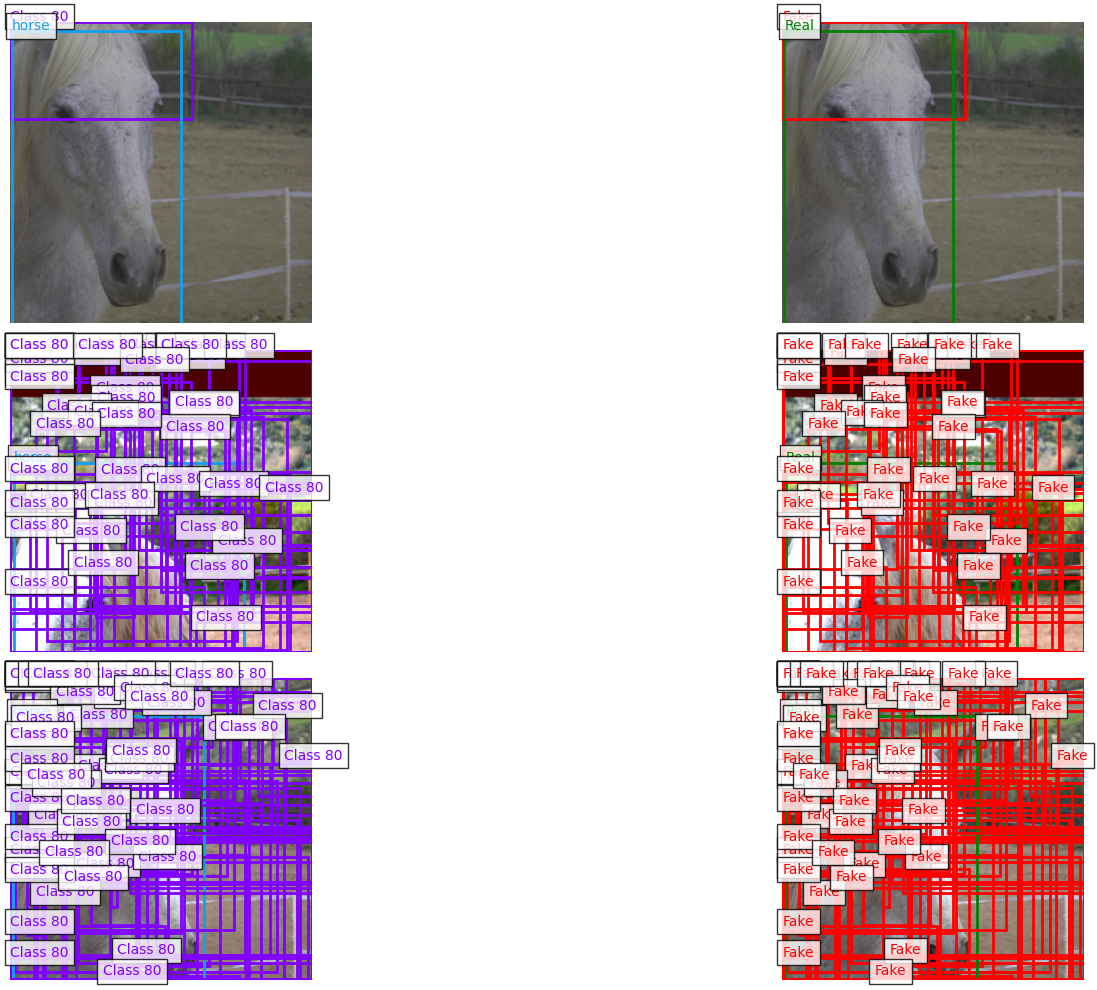

In [43]:
from data.tokenizer import TokenProcessor
from data.dataset import Pix2SeqDataset, Pix2SeqCollator
from torch.utils.data import DataLoader

pix2seq_ds = Pix2SeqDataset(
    base_dataset=ds,
    num_classes=80,  # COCO classes
    training=True,
    max_num_objects=100,
    image_size=640,
)

def plot_examples(num_examples, ds_idx):
    fig, ax = plt.subplots(num_examples, 2, figsize=(20, 10))

    for i in range(num_examples):
        sample = pix2seq_ds[ds_idx]

        show_image_with_boxes(
            sample["image"],
            sample["boxes"],
            sample["labels"],
            category_names=category_names,
            normalized_boxes=True,
            ax=ax[i, 0],
        )

        show_image_with_boxes(
            sample["image"],
            sample["boxes"],
            sample["labels"],
            category_names=category_names,
            normalized_boxes=True,
            real_noise_coloring=True,
            ax=ax[i, 1],
        )
    fig.tight_layout()


plot_examples(3, 62)

When first inspecting the image outputs, I was surprised at the number of fake boxes that the paper's approach recommended, however this does appear to work well in practice!

This data augmentation methodology transforms a potential weakness of autoregressive models (sensitivity to early errors) into a strength, creating a system that is both conceptually elegant and practically robust; the model learns to predict the `FAKE` class token for noise objects while predicting correct coordinates and classes for real objects. This creates a model that's simultaneously a generator (for real objects) and a discriminator (for fake objects).

## The Training Pipeline

Now that we have explored how Pix2Seq creates a rich training signal through data augmentation - generating real objects with small perturbations, shifted boxes as hard negatives, random boxes as easy negatives, and the sophisticated sequence augmentation strategy - we need to understand how the model actually learns from this complex mixture of real and synthetic data.

The good news is that the overall training process is fairly generic, and should be familiar to anyone that has trained language models. The key insight is that not all tokens should contribute equally to the loss. The fake boxes we just created serve a specific purpose: teaching the model to recognize and reject invalid detections. But this requires adapting our training target so that we handle different token types appropriately; this is achieved through a carefully designed token weighting scheme.

Most of the complexity in our data pipeline - handling variable-length sequences, data augmentation, and tokenization -  happen when we collate the data into batches:

```python
class Pix2SeqCollator:
    def __call__(self, batch):
        """Convert batch of images/boxes into model inputs."""
        # Standard image processing
        images = torch.stack([x["image"] for x in batch])
        
        # Variable-length box sequences need padding
        max_boxes = max(x["num_boxes"] for x in batch)
        
        # Apply box augmentation during training
        if self.is_training:
            augmented_boxes, augmented_labels = [], []
            for item in batch:
                boxes, labels = self.bbox_augmentor.augment_bbox(
                    item["boxes"], item["labels"], 
                    n_noise_bbox=max_boxes - item["num_boxes"]
                )
                augmented_boxes.append(boxes)
                augmented_labels.append(labels)
        
        # Convert to token sequences
        input_seq, target_seq, token_weights = self.token_processor.build_sequences(
            boxes=torch.stack(augmented_boxes),
            labels=torch.stack(augmented_labels)
        )
        
        return {
            "image": images,
            "input_seq": input_seq,
            "target_seq": target_seq, 
            "token_weights": token_weights
        }
```

During this process, we calculate our token weights whilst we build our sequences in our tokenizer as follows:
```python
    # Calculate token weights for objects
    # Check which objects are fake/noise objects by comparing their labels to the fake class token
    is_fake = target_labels == self.FAKE_CLASS_TOKEN

    # Calculate weights for bounding box coordinate tokens (4 tokens per object: y_min, x_min, y_max, x_max)
    # fake objects should learn to predict "fake" class but not learn coordinates
    bbox_weights = torch.where(
        is_padding.unsqueeze(-1), # Expand padding mask to match box dimensions [B,N,1] -> [B,N,4]
        torch.zeros_like(boxes, dtype=torch.float32), # Padding tokens get weight 0 (ignored in loss)
        torch.where(
            is_fake.unsqueeze(-1), # Expand fake mask to match box dimensions [B,N,1] -> [B,N,4]
            torch.full_like(boxes, self.noise_bbox_weight, dtype=torch.float32), # Fake objects get specified weights for coordinates
            torch.ones_like(boxes, dtype=torch.float32), torch.ones_like(boxes, dtype=torch.float32),  # Real objects get weight 1.0 (fully learn coordinates)
        ),
    )

    # Calculate weights for class tokens (1 token per object)
    # fake objects still get weight 1.0 for class tokens so model learns to predict "fake"
    label_weights = torch.where(
        is_padding,  # Check if this is a padding token
        torch.zeros_like(labels, dtype=torch.float32), # Padding tokens get weight 0 (ignored)
        torch.ones_like(
            labels, dtype=torch.float32
        ),  # Both real AND fake objects get weight 1.0 for class prediction
    )

    # Combine coordinate and class weights into a single weight tensor
    # Each object has 5 tokens: [y_min, x_min, y_max, x_max, class]
    token_weights = torch.cat(
        [bbox_weights, label_weights.unsqueeze(-1)], dim=-1
    )  # [B, N, 5] where 5 = 4 coordinate tokens + 1 class token
```

This should enable to model to learn:
* For real objects (from ground truth + jittering): Learn both coordinates and class correctly (all weights = 1.0)
* For fake objects (from shifting/random generation): Learn to classify as "fake" but don't waste effort on coordinate precision (bbox weights = 0.0, class weight = 1.0)
* For padding: Ignore completely (all weights = 0.0)


During my implementation, I was initially confused: if these are fake objects, shouldn't we ignore them entirely? However, thinking more carefully, the rationale becomes clear; the model must learn to actively reject invalid objects by predicting the FAKE token, rather than simply ignoring them.
This creates a discriminative model that can distinguish between valid objects and noise during inference. When the model encounters a spurious detection during generation, it has learned to classify it as fake rather than getting confused.

This results in behaviour where the model learns to recognise non-object predictions (by predicting the `FAKE` class) without wasting capacity learning the specific coordinates of synthetic noise. It's adversarial training embedded directly into the sequence modelling framework.

### The Loss Function

With our token weighting in place, the actual loss function becomes straightforward:

```python
class Pix2SeqTrainer
    def _calculate_loss(self, logits, target_seq, token_weights):
        """Standard language modelling loss with token weighting."""
        
        # Simple cross-entropy - the same as language modelling
        loss = F.cross_entropy(logits, target_seq, reduction='none')
        
        # Apply our carefully designed weights
        weighted_loss = loss * token_weights
        
        # Normalize by valid tokens
        num_valid = (target_seq != self.PADDING_TOKEN).sum().clamp(min=1)
        return weighted_loss.sum() / num_valid
```

The elegance is stunning. Decades of object detection research have produced increasingly sophisticated loss functions - focal loss for class imbalance, IoU loss for localization, complex matching algorithms for assignment. However, with this approach, the complexity has been moved from the loss function into the data representation; a profoundly different design philosophy that leverages the power of sequence modelling rather than fighting against it. As a result, we are left with the same cross-entropy loss used to train language or classification models.

### Exploring the Architecture

Now that we have unpacked our loss function, let's look at the model architecture itself. If we recall a standard transformer architecture - if not, I'd recommend [this blog post](https://medium.com/data-science/de-coded-transformers-explained-in-plain-english-877814ba6429?source=friends_link&sk=412e53f175d3f42b32ab1e59ccd8d7cf) - we will recognise that this is a fairly straightforward implementation; there are no specialized components and no task-specific heads - just a clean encoder-decoder transformer that treats object detection as a sequence-to-sequence problem.

Let's understand what the key components are:

![Pix2seq](./images/pix2seq.png)

It may look complex at first, so let's break down what the high-level information flow through a simplified forward pass:

```python

class Pix2seqModel(nn.Module):

    def forward(self, images, tgt, tgt_padding_mask=None):
        encoded, _ = self.encode(images)
        return self.decode(tgt, encoded, tgt_padding_mask=tgt_padding_mask)
```

As we would expect, our image inputs go through an encoding step, and then the output of this, along with the sequence containing our predictions are passed through a decoding step. Let's break these down in turn, starting with `encode`:

```python
class Pix2seqModel(nn.Module):

    def encode(self, images):
        """Process images into contextualized patch representations."""
        # Extract patch features using pretrained ViT
        features = self.vit.forward_features(images)  # [B, num_patches+1, embed_dim]
        
        # Project to model dimension
        encoded = self.encoder_proj(features)
        encoded = self.encoder_norm(encoded)
        
        # Add positional information
        pos_emb = self.pos_embed(encoded)
        encoded = encoded + pos_emb
        
        # Apply transformer layers for cross-patch reasoning
        for encoder_block in self.transformer_encoder:
            encoded = encoder_block(encoded)
        
        return encoded
```

Here, we can see that the encoder is fairly standard - a Vision Transformer followed by additional transformer layers. When I first looked at this architecture, I questioned whether the additional encoder layers (beyond the pretrained ViT) were necessary for performance. I ran a few experiments removing these and found that the model could learn the task, but much more slowly. Therefore, I suspect that we could simplify this architecture further if we were simply to scale up the vision encoder. However, these experiments are costly and time consuming, so I chose not to pursue this further.


Now, let's explore the `decode` method, where object detection transforms into sequence modelling:

```python
def decode(self, tgt, encoder_input, use_cache=False):
    """Generate token sequences autoregressively."""
    # Embed tokens and add learned positional encodings
    decoded = self.token_embedding(tgt)
    decoded = decoded + self.dec_pos_embed[:, :tgt.size(1)]
    
    # Apply causal transformer layers with cross-attention
    for decoder_block in self.transformer_decoder:
        decoded = decoder_block(
            decoded,                    # Self-attention over generated tokens
            encoder_input,              # Cross-attention to image features
            use_cache=use_cache         # KV caching for efficient inference
        )
    
    decoded = self.decoder_norm(decoded)
    return self.output_proj(decoded)    # Project to vocabulary
```

What struck me during implementation was how the cross-attention mechanism naturally handles the vision-language bridge. Each generated token can attend to relevant parts of the image, creating a dynamic, content-aware generation process. Unlike DETR's fixed object queries, this approach lets the model decide what to attend to based on what it's currently generating.

Note that here, the paper uses learned positional embeddings for the decoder sequence, not sinusoidal ones.

#### Modern Architecture Experiments: Beyond the Original Paper

While I implemented a faithful version following the paper's architecture (standard transformer with sinusoidal position encoding), I also couldn't resist experimenting with modern transformer components. This led to my `LlamaPix2Seq` variant that incorporates:

**Rotary Position Embeddings (RoPE)**: Instead of learned position embeddings, I implemented RoPE for both the decoder sequence positions and the vision encoder spatial positions:

```python
class RoPEMultiHeadAttention(MultiHeadAttention):
    def __init__(self, embedding_dim, num_heads, q_max_seq_len=8192, 
                 kv_max_seq_len=None, q_rope_base=500000.0, k_rope_base=None):
        # Different RoPE parameters for query vs key/value sequences
        # Allows different context lengths for text and vision
        super().__init__(embedding_dim, num_heads, is_causal, bias, dropout)
        
        # Precompute RoPE embeddings for different sequence types
        q_cos, q_sin = precompute_rope_params(
            head_dim=self.head_dim, context_length=q_max_seq_len, theta_base=q_rope_base
        )
        
        if q_max_seq_len != kv_max_seq_len:
            k_cos, k_sin = precompute_rope_params(
                head_dim=self.head_dim, context_length=kv_max_seq_len, theta_base=k_rope_base
            )
        else:
            k_cos, k_sin = q_cos, q_sin

**SwiGLU Feed-Forward Networks**: Replacing standard MLP layers with the SwiGLU variant from LLaMA:

```python
class SwiGLUFFN(nn.Module):
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))
```

**RMSNorm**: Using RMS normalization instead of LayerNorm for potentially better training stability.

These modifications were partly curiosity-driven - I wanted to see if modern language modelling advances would transfer to this vision-language setup. The results were encouraging - obtaining a similar level of performance - but converged much slower than the paper's variant. I suspect that, as this architecture has fewer biases, this would scale better if we were to increase the size of our training dataset.

### Putting It All Together

Now that we understand our data pipeline, model and loss function, the training process looks remarkably similar to any language model:

```python
class Pix2SeqTrainer(Trainer):
    def calculate_train_batch_loss(self, batch):
        images = batch["image"]              # [B,3,H,W]
        input_seq = batch["input_seq"]       # [B,S] with noise objects
        target_seq = batch["target_seq"]     # [B,S] shifted by one
        token_weights = batch["token_weights"] # [B,S] weighting scheme
        
        # Forward pass through encoder-decoder
        logits = self.model(images, input_seq)
        
        # Reshape for standard cross-entropy loss
        B, S, V = logits.shape
        logits = logits.view(-1, V)
        target_seq = target_seq.view(-1)
        token_weights = token_weights.view(-1)
        
        # The same loss function as any autoregressive model
        loss = F.cross_entropy(logits, target_seq, reduction='none')
        weighted_loss = loss * token_weights
        
        # Normalize by number of valid (non-padding) tokens
        num_valid = (target_seq != self.PADDING_TOKEN).sum().clamp(min=1)
        return weighted_loss.sum() / num_valid
```

What continually amazed me during training was how *normal* everything felt. No complex loss balancing, no learning rate schedules for different heads, no careful initialization of specialized components. It's just sequence modelling applied to a vision task; and it felt like the future!

## Inference: From Slow to Fast

One of the first things I discovered during inference was that autoregressive generation is slow. Really slow. For each object detected, the model needs to generate 5 tokens sequentially, and naively, each token generation requires processing the entire image through the vision encoder. With 10 objects in an image, that's 50 sequential forward passes!

### The Speed Problem

```python
def naive_inference(self, images):
    """Slow inference - processes image for every token."""
    batch_size = images.size(0)
    sequences = torch.full((batch_size, 1), self.BOS_TOKEN)
    
    for step in range(self.max_sequence_length):
        # THIS IS THE BOTTLENECK: Re-encoding image every step
        encoder_output = self.encode(images)  # Expensive!
        logits = self.decode(sequences, encoder_output)
        
        next_tokens = self.sample_next_token(logits[:, -1])
        sequences = torch.cat([sequences, next_tokens], dim=1)
        
        if all_sequences_ended(sequences):
            break
    
    return sequences
```

The problem is that we're re-encoding the same image features for every single token generation step. This is wasteful - as our image features don't change during sequence generation.

### The Solution: KV Caching and Encoder Reuse
The solution involves two complementary optimizations that dramatically speed up inference:

```python
def fast_inference(self, images):
    """Fast inference with cached computations."""
    batch_size = images.size(0)
    
    # OPTIMIZATION 1: Encode images ONCE and reuse
    encoder_output = self.encode(images)  # Only computed once!
    
    # Initialize decoder state
    sequences = torch.full((batch_size, 1), self.BOS_TOKEN)
    
    for step in range(self.max_sequence_length):
        # OPTIMIZATION 2: Use cached decoder states - only process new token
        logits = self.decode(
            sequences[:, -1:],      # Only the last token
            encoder_output,         # Reused encoder output
            use_cache=True,         # Enable KV caching
        )
        
        # Apply constraints and sample
        allowed_tokens = self.get_allowed_tokens(step, sequences)
        next_tokens = self.constrained_sample(logits, allowed_tokens)
        
        sequences = torch.cat([sequences, next_tokens], dim=1)
        
        if self.all_ended(sequences):
            break
    
    return sequences
```

Let's break down what's happening with a concrete example. Suppose that we are generating a sequence of 20 tokens (4 objects × 5 tokens each):

*Encoder Reuse* saves us from redundant computation:

```python
# Naive: Re-encode the same image 20 times
step 1: encode(image) → decode([BOS])
step 2: encode(image) → decode([BOS, token1])  # Same image!
step 3: encode(image) → decode([BOS, token1, token2])  # Same image again!
...

# Optimized: Encode once, reuse everywhere
encode(image) → cache result
step 1: decode([BOS]) using cached encoding
step 2: decode([BOS, token1]) using cached encoding
step 3: decode([BOS, token1, token2]) using cached encoding
```

This gives us a nice constant speedup, but the real complexity issue is in the decoder.

*KV Caching* is where the magic happens. In standard transformer decoding, each step has to reprocess the entire sequence:

```python
# Without KV caching: O(S²) complexity
step 1: process 1 token  ([BOS])
step 2: process 2 tokens ([BOS, token1])
step 3: process 3 tokens ([BOS, token1, token2])
...
step 20: process 20 tokens ([BOS, token1, ..., token19])

# Total work: 1 + 2 + 3 + ... + 20 = 210 token processing operations
# Generally: 1 + 2 + ... + S = S(S+1)/2 ≈ S²/2 = O(S²)
```

However, with KV caching, we store the key and value representations from previous steps:

```python
# With KV caching: O(S) complexity  
step 1: process 1 token ([BOS]) + cache its K,V states
step 2: process 1 token ([token1]) + reuse cached K,V from step 1
step 3: process 1 token ([token2]) + reuse cached K,V from steps 1-2
...
step 20: process 1 token ([token19]) + reuse cached K,V from steps 1-19

# Total work: 1 + 1 + 1 + ... + 1 = 20 token processing operations  
# Generally: S × 1 = O(S)
```

Therefore, we can summarise the combined impact of these optimisations as follows:
* *Encoder reuse*: O(S) → O(1) for image processing (constant factor speedup)
* *KV caching*: O(S²) → O(S) for sequence processing (fundamental complexity reduction)

More importantly, the O(S) instead of O(S²) scaling means the speedup gets even more dramatic for images with many objects.

Together, these optimizations made inference significantly faster on my test images - transforming it from unusably slow (several seconds per image) to practically viable (hundreds of milliseconds).

### Constrained Generation: Enforcing Structure

During inference, I quickly realized that not all token sequences make sense as object descriptions. Generating `[y_min=50, x_min=30, y_max=20, x_max=70, class=car]` produces an invalid box where `y_max < y_min`. The original paper mentions using nucleus sampling for generation but doesn't detail structural constraints, so this became one of my key implementation additions.

I implemented a constraint system that enforces structural validity based on position in the 5-token pattern:

```python
class TokenMaskCache:
    def get_allowed_tokens(self, pattern_pos: int, cur_seq: torch.Tensor):
        """Constrain valid tokens based on sequence position."""
        
        if pattern_pos == 0:  # y_min position
            # Can generate coordinates or end sequence
            allowed = coordinate_tokens + [EOS_TOKEN]
            
        elif pattern_pos == 1:  # x_min position  
            # Only coordinates allowed
            allowed = coordinate_tokens
            
        elif pattern_pos == 2:  # y_max position
            # Must be greater than y_min from 2 positions back
            y_min = cur_seq[:, -2] - self.coord_vocab_shift
            allowed = coordinate_tokens[y_min+1:]
            
        elif pattern_pos == 3:  # x_max position
            # Must be greater than x_min from 2 positions back
            x_min = cur_seq[:, -2] - self.coord_vocab_shift  
            allowed = coordinate_tokens[x_min+1:]
            
        elif pattern_pos == 4:  # class position
            # Only valid class tokens
            allowed = class_tokens
            
        return allowed
```

This constraint system ensures that every generated sequence corresponds to a valid bounding box. What's clever is that these constraints don't hurt generation quality - they actually help by preventing the model from wasting probability mass on impossible sequences.

### Sampling approach

For the actual token sampling, I implemented nucleus sampling (top-p) combined with the structural constraints:

```python
def sample_next_token(self, logits, allowed_tokens):
    """Sample from constrained distribution using nucleus sampling."""
    # Apply hard structural constraints
    constrained_logits = logits.masked_fill(~allowed_tokens, float('-inf'))
    
    # Apply nucleus sampling for diversity
    if self.top_p > 0:
        sorted_logits, sorted_indices = torch.sort(constrained_logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        
        # Remove tokens beyond cumulative threshold
        indices_to_remove = cumulative_probs > self.top_p
        indices_to_remove[..., 1:] = indices_to_remove[..., :-1].clone()
        indices_to_remove[..., 0] = 0
        
        # Apply the mask
        for batch_idx in range(constrained_logits.size(0)):
            batch_indices_to_remove = sorted_indices_to_remove[batch_idx].scatter(
                0, sorted_indices[batch_idx], sorted_indices_to_remove[batch_idx]
            )
            constrained_logits[batch_idx][batch_indices_to_remove] = float('-inf')
    
    # Sample from the refined distribution
    probs = F.softmax(constrained_logits / self.temperature, dim=-1)
    return torch.multinomial(probs, num_samples=1)
```

The interplay between structural constraints and probabilistic sampling creates a generation process that's both valid and diverse - exactly what we want for object detection.



# Results

For the training runs that I conducted, I largely followed the recipes outlined in the paper, with the notable exception being that I used a WSD learning rate scheduler, to make it easier to continue training from checkpoints; the full list of hyperparameters are stored as config files in the codebase. Training on 4xA100 GPUs, I was able to reproduce the results in the paper to a similar order or magnitude (~44 AP) when training on COCO from scratch for 300 epochs with image sizes of 640x640.

Some examples of correct predictions can be seen below:

![kite-prediction](./images/predictions/kite.png)

![ski-prediction](./images/predictions/ski.png)

![multi-prediction](./images/predictions/sheep.png)

However, while analyzing my training results, I discovered something that initially seemed like a bug in my evaluation code: intermediate model checkpoints sometimes produced better visual results than the final, "best" model. Let's explore this further, and reason about why this could be the case.

## Error analysis - inspecting predictions from intermediate checkpoints

Let's examine three concrete examples from my training logs that illustrate different aspects of this puzzling behavior. These patterns were repeated across dozens of images and multiple training runs. I initially thought there was a bug in my checkpoint loading, but after careful verification, these types of patterns were real and systematic.

### Example 1: The Sheep that became a Dog

Consider the following image - containing a clearly visible sheep plus some small, difficult-to-identify objects in the background - and the predictions that the model made at different points in its training cycle.

![sheep-change](./images/predictions/sheep-change.png)

We can see that, at epoch 20, the model correctly labels the sheep as "sheep" and identifies a small background object as "car" (which appears correct upon close inspection). It is missing some very hard-to-see labels (person, cell phone) that I honestly couldn't identify myself. However, from epochs 90-300, the learned to call the sheep a "dog" - despite getting it right initially.

This is particularly striking: the model learned to be wrong about something it initially got correct. To me, this suggests it's not just learning object recognition, but learning the specific labelling patterns present in the training data.


### Example 2: The Umbrella and Boots

Now, lets take a look at a different example, where the initial predictions are not definitively better, but demonstrates some interesting change.

![umbrella-change](./images/predictions/umbrella-change.png)

At epochs 10-20, the model attempts to predict an object around the boots (getting the label wrong), but completely misses the umbrella. By epoch 40, the model makes no predictions at all - a complete detection failure. However, from epoch 50 onwards through epoch 300, the model correctly predicts the umbrella (both position and label) but completely ignores the boots.

What's remarkable is this progression: the model went from recognizing that something was there (the boots) to giving up entirely, to finally learning to replicate the exact annotation pattern - including the systematic omission of clearly visible objects. This shows how the model learns not just what to detect, but what not to detect based on training patterns.


### Example 3: The Sandwich Classification Confusion


In our final example, we have multiple overlapping objects labelled as "sandwiches" (though they look more like crackers with spread to me), plus barely visible background objects (keyboard, remote, mouse).

![sandwich-change](./images/predictions/sandwich-change.png)


At epoch 120, the model predicts all the sandwich objects as "pizzas" - which is arguably a reasonable guess given their appearance. It correctly identifies the keyboard and mouse but misses the remote. By epoch 210, the model shows significant improvement: it correctly labels 3 objects as "sandwich," though it mislabels 2 others as "donut" (which should also be "sandwich"). It gets the keyboard and mouse correct and now detects the remote, though it calls it a "cell phone." While not perfect, this represents much more complete detection.

But then, by epoch 300, the model's performance has degraded: it predicts one object correctly as "sandwich," another as "donut," and seems to give up on detecting the rest entirely. It still gets the keyboard and mouse right, but the more complete predictions from epoch 210 have deteriorated into uncertain, partial detections.

This progression illustrates the core issue: reasonable visual guess ("pizza") → improved but imperfect detection → degraded performance with missing objects. The intermediate checkpoint at epoch 210, while not perfect, showed better object detection completeness than the final model. This suggests that continued training caused the model to become more conservative and uncertain, preferring to miss objects entirely rather than risk confident misclassification.

## How Training Dynamics Drive These Behavior

The examples above might seem like quirky training anomalies, but they're actually the inevitable result of how neural networks learn patterns from data. To understand why the model learned to ignore boots, misclassify sheep as dogs, and become uncertain about sandwiches, we need to look at the different mechanisms at play - from dataset-wide pattern learning to token-level loss calculations. Breaking down the maths reveals that what appears counterintuitive is actually the model optimizing perfectly, just not always for what we want.


### Learning Dataset Patterns Over Visual Reality

The sheep-to-dog example reveals how models learn statistical patterns across the entire dataset that can override correct behavior on individual images. This is likely caused by contextual and behavioral pattern learning across thousands of examples:

The sheep-to-dog example reveals the most troubling aspect of this training dynamic. Let's see how cross-entropy loss drives the model to learn statistical patterns rather than visual features:

```python
# What likely happens across the COCO dataset:
# Image 1: [animal + jumping + near house + window] → labelled as "dog" 
# Image 2: [animal + reaching up + residential setting] → labelled as "dog"
# Image 3: [animal + jumping + near window + house] → labelled as "sheep" (our example)
# Image 4: [animal + standing on hind legs + doorway] → labelled as "dog"
# ... hundreds more examples

# The model learns: these contextual features → "dog" (95% of the time)
# Statistical pattern overrides individual image correctness
```

The model develops learned associations between contextual patterns and label frequencies. While our specific sheep image is consistently labelled "sheep," the model encounters overwhelming evidence across the dataset that animals in this context - jumping up to windows outside houses - are almost always labelled as "dog." Sheep in COCO are typically found in pastoral settings, fields, or farms, not exhibiting 'dog-like' behaviors in residential contexts.

We can think about this in the following way. For the purposes of example, suppose the contextual features learned by the model align with concepts that we may define. We could represent this as:

```python
## Model's learned contextual features (simplified):
contextual_features = [
    near_window: 0.9, 
    residential_setting: 0.8, 
    jumping_behaviour: 0.9,
    human_interaction_context: 0.7
]

# Learned associations across dataset:
if near_window + jumping_behaviour + residential_setting > threshold:
    most_likely_label = "dog"  # Based on overwhelming dataset evidence
    
# This contextual pattern overrides visual features for individual images
```
Of course, it is unlikely that the model would learn these types of features, but this helps to illustrate the issue.

This explains why the model would learn to be wrong: it's not learning to distinguish sheep from dogs based on visual features alone, but learning that context and behavior are stronger predictors of labels in the training data. A sheep acting like a dog, in a dog-like context, gets predicted as a dog because that's what the statistical evidence across thousands of images suggests.

### Cross-Entropy Loss and Sequence Alignment Issues

The umbrella and boots example shows where cross-entropy loss directly drives problematic behavior through token-level calculations. For a refresher on exactly how cross-entropy loss works, a brief overview can be found [here](https://medium.com/@chris.p.hughes10/a-brief-overview-of-cross-entropy-loss-523aa56b75d5?source=friends_link&sk=d40004597b150278baf3bb79633deff7).

When the model at epoch 20 tries to predict the boots, here's what the loss computation looks like:

```python
# What the model generates (epoch 20):
predicted_sequence = [BOS, y1, x1, y2, x2, "shoe", EOS]  # Trying to detect boots

# What the ground truth expects:
target_sequence = [BOS, y3, x3, y4, x4, "umbrella", EOS]  # Only umbrella labelled

# Cross-entropy loss calculation: -log(p(target_token))
# Let's calculate the loss for each position:

# Position 0: BOS token
model_probs = [0.95, 0.01, 0.01, ...]  # Model is confident about BOS
target_token = BOS  # Ground truth wants BOS
loss_pos_0 = -log(0.95) = 0.05  # Low loss - both agree on BOS

# Position 1: First coordinate (y_min)
model_probs = [0.02, 0.03, 0.04, ..., 0.78, ...]  # Model confident about boots y-coord
target_token = y3  # Ground truth wants umbrella y-coordinate  
loss_pos_1 = -log(0.03) = 3.5  # High loss - coordinate mismatch

# Position 2-4: Remaining coordinates
# Similar misalignment, each contributing ~3-4 to the loss

# Position 5: Class token - this is where it gets really bad
model_probs = [0.01, 0.02, ..., 0.85, ..., 0.001, ...]  # Very confident it's a shoe
target_token = "umbrella"  # Ground truth wants umbrella
loss_pos_5 = -log(0.001) = 6.9  # Massive loss - class completely wrong

# Position 6: EOS token
model_probs = [0.05, 0.9, 0.02, ...]  # Model thinks sequence should end
target_token = EOS  # Ground truth also wants EOS here  
loss_pos_6 = -log(0.9) = 0.1  # Low loss - both agree on ending

# Total loss for this sequence:
total_loss = 0.05 + 3.5 + 3.2 + 3.8 + 3.4 + 6.9 + 0.1 = 20.95

```

Note that here, we assumed that the model predicted the class correctly, even though it didn't in the prediction we observed. However, we can notice that this actually wouldn't make any difference! The model would still be penalised that the class is incorrect, regardless of whether the predicted class was `shoe` or `fire hyrant`; recall also that there is no concept of class similarity for cross entropy loss.

The model receives an enormous negative signal (loss of ~21) for trying to detect the boots, even though they're clearly visible. But here's another crucial factor: **the order in which objects are generated matters enormously for the loss calculation**.

Consider what would happen if the model had generated the umbrella first, then the boots:
```python
# Alternative generation order:
predicted_sequence = [BOS, y3, x3, y4, x4, "umbrella", y1, x1, y2, x2, "shoe", EOS]
target_sequence =    [BOS, y3, x3, y4, x4, "umbrella", EOS]

# Loss calculation:
# Positions 0-5: Perfect match! Each position ~0.05 loss = 0.3 total
# Position 6: Model predicts y1 (boots y-coord), target wants EOS
model_probs = [0.02, 0.01, ..., 0.78, ..., 0.001, ...]  # Model confident about y1
target_token = EOS  # Ground truth wants sequence to end
loss_pos_6 = -log(0.001) = 6.9  # High loss for predicting coordinate instead of EOS

# Positions 7+: Depend on how padding/truncation is handled in implementation
# Total loss: 0.3 + 6.9 + padding penalties = ~8-10 (much lower than 21)
```
*Note: The exact loss depends on implementation details like sequence padding and length normalization, but the key point is that matching the first 6 tokens perfectly gives much lower loss than misaligning from the very beginning*

This reveals a fundamental issue with sequence-based object detection: **the model learns that generating "certain" objects first minimizes loss**, even if other objects are equally visible. The random shuffling during training helps expose the model to different orderings, but during any specific forward pass, the order still dramatically affects the loss.

This creates additional learned biases:
- Generate "typically labelled" objects first (umbrellas) 
- Suppress "typically unlabelled" objects (boots) entirely
- Avoid generating objects that might cause sequence misalignment

The loss function provides **no partial credit** for recognizing that there's an object where the boots are located, and additionally **penalizes the boots detection more severely** if it's generated before the "correct" umbrella. Even with random shuffling, this ordering dependency reinforces the model's bias toward replicating incomplete annotation patterns.

### Cross-Entropy Loss and Learned Uncertainty

The sandwich confusion shows how uncertainty emerges from inconsistent training signals rather than being actively learned. Let's see the loss calculations:

```python
# Epoch 120: Model confidently predicts "pizza" 
model_probs_pizza = [0.01, 0.02, ..., 0.78, ..., 0.05, ...]  # Confident guess
target_token = "sandwich"  # Ground truth wants sandwich
loss_pizza = -log(0.05) = 3.0  # Moderate loss - wrong but reasonable guess

# Epoch 300: Model now uncertain and confused
model_probs_confused = [0.15, 0.18, 0.12, 0.14, 0.11, ...]  # Very uncertain
target_token = "sandwich"  # Still wants sandwich  
loss_confused = -log(0.14) = 1.97  # Lower loss but from learned uncertainty
```
This shows how uncertainty emerges from inconsistent training signals rather than being actively learned. The model doesn't develop "learned helplessness" - it finds the optimal solution given conflicting data. When the training set contains crackers labelled as both "sandwich" and "pizza," the model learns a probability distribution that minimizes loss across all these inconsistent examples.

The model's probability distribution is now much flatter - it assigns roughly equal probability to "sandwich" (0.14), "pizza" (0.18), "donut" (0.15), etc. This isn't learned uncertainty as a strategy, but rather the mathematically optimal response to inconsistent training labels. The loss hierarchy is: confident right (0.2) < uncertain (1.97) < confident wrong (3.0).

### The Training Progression: Multiple Mechanisms at Work

The three examples above were chosen to illustrate different learning mechanisms working together that I observed across training runs:

**Early Training (Epochs 1-50):**
- Model attempts to detect visible objects based on visual features
- Often gets labels wrong but shows good visual recognition
- Makes confident guesses about ambiguous cases ("pizzas" for crackers)  
- **Higher training loss, better visual understanding**

**Mid Training (Epochs 50-150):**
- Model starts learning dataset-wide statistical patterns (sheep → dog transition)
- Cross-entropy loss drives suppression of unlabelled objects (boots disappear)
- Begins developing learned uncertainty on inconsistent labels
- **Decreasing loss, emergence of learned biases**

**Late Training (Epochs 150+):**
- Model closely replicates annotation patterns (umbrella yes, boots no)
- Statistical patterns override individual image correctness (sheep as dog)
- Cross-entropy loss creates conservative uncertainty on ambiguous cases
- **Lowest training loss, perfect replication of dataset biases**

The model learns to **predict the dataset patterns rather than detect objects**. It develops multiple types of learned associations: contextual patterns (sheep → dog), annotation completeness patterns (boots typically unlabelled), and uncertainty patterns (ambiguous food items).



# Challenges with COCO Annotations

When conducting the error analysis for this project, I was reminded at just how many potential issues there are with the COCO dataset; these specific examples reveal systematic issues with the COCO dataset that affect all detection models but are particularly visible in Pix2Seq. Whilst COCO is one of the most widely used object detection datasets available, it suffers from annotation problems that are likely present across many human-annotated detection datasets:

* **Missing Object Annotations**: Background or secondary objects are systematically ignored by annotators. My umbrella/boots example illustrates this perfectly - the boots are clearly visible but unlabelled, representing a widespread pattern where annotators focus on "primary" objects and miss secondary ones.

* **Scale-Based Annotation Bias**: Small objects (area < 32² pixels) are systematically under-annotated compared to large objects. Annotators often miss or skip tiny objects that are clearly visible, like the small background items in my sandwich example (keyboard, mouse, remote).

* **Inconsistent Classification Patterns**: Similar-looking objects are labelled inconsistently depending on context. My sheep-to-dog example reveals how the model learns statistical patterns rather than visual distinctions - likely because COCO contains animals in ambiguous contexts that get labelled differently by different annotators.

* **Complex Scene and Annotation Fatigue**: In images with many objects (busy street scenes, cluttered rooms), annotation quality degrades significantly. Later objects in the annotation process are more likely to be missed as annotator attention diminishes. This explains why models learn to be conservative about detecting multiple objects.

* **Class Boundary Ambiguity**: The distinction between similar classes varies significantly between annotators. My sandwich/pizza/crackers confusion reflects broader issues with subjective categories - "cup" vs "mug," "couch" vs "chair," "truck" vs "bus" - that create systematic inconsistencies.

* **Contextual Annotation Bias**: Objects in "unusual" contexts are more likely to be missed or mislabelled. A sheep jumping at a house window (dog-like behaviour) gets processed through learned statistical patterns rather than careful visual analysis.

* **Occlusion and Partial Object Handling**: Partially occluded objects are inconsistently labelled. Sometimes a person's head behind a car gets annotated, sometimes it doesn't, depending on annotator judgment and fatigue.

* **Temporal and Cultural Inconsistencies**: COCO was annotated over multiple years by different teams, leading to evolving standards. Additionally, annotators may be more likely to notice and correctly label objects familiar to their cultural background.

* **Image Boundary Effects**: Objects partially cut off at image edges are inconsistently handled - sometimes annotated, sometimes ignored, creating learned biases about when to detect truncated objects.

Therefore, a model trained to minimize cross-entropy loss learns these annotation patterns as **features, not bugs**, e.g.:

- "Objects like boots near umbrellas are typically not labelled"
- "Sheep-like animals are more often labelled as dogs in certain contexts"  
- "Small background objects are inconsistently labelled, so confidence should be low"
- "Objects in complex scenes beyond the first few are usually ignored"
- "Partially occluded objects depend on context for labelling"
- "When in doubt about ambiguous food categories, avoid confident predictions"

These aren't random errors - they're systematic learned biases that help the model achieve lower training loss by matching the annotation patterns rather than detecting all visible objects. The model essentially learns to replicate human annotator behaviour, including their biases, fatigue patterns, and inconsistencies.

The problems stem from fundamental challenges in large-scale human annotation: subjectivity, fatigue, inconsistent guidelines, and the inherent difficulty of exhaustively labelling complex visual scenes.

## Why I Continued with COCO Despite These Issues

Despite these significant challenges, I chose to continue using COCO for two reasons:

1. **Consistency with the paper**: To fairly evaluate the approach and compare with reported results; providing a measure for me to work towards
2. **Industry standard**: COCO remains the most widely used benchmark, making results comparable with other methods

But this experience reinforced that in a production setting, you'd want to carefully audit your training data quality and potentially use more complete annotations or alternative training strategies.

## Why This is Particularly Problematic for Pix2Seq

While this issue affects all object detection models to some degree, it's **especially pronounced in Pix2Seq** for several key reasons:

### 1. Sequence-to-Sequence vs Spatial Matching
Traditional object detection methods use flexible spatial matching algorithms (Hungarian matching in DETR, IoU-based assignment in YOLO/R-CNN) that can partially mitigate annotation issues. If a predicted box overlaps significantly with a ground truth box, it might still be considered a "correct" match during training, even if the class is slightly different or the box coordinates don't align perfectly.

Pix2Seq, like language models, uses **token-by-token sequence matching** with cross-entropy loss. Either each token in the sequence matches exactly, or it doesn't. When the model predicts an unlabelled object, every subsequent token in the sequence becomes misaligned, creating cascading penalties.

### 2. Annotation Quality vs Self-Supervision
The key difference isn't in the training methodology - language models use the same direct sequence matching approach. The difference is in **data quality and systematic omissions**:

- **Language modelling**: While there are often multiple valid ways to continue a text, the training data represents one valid path that was actually written. The model learns from complete, naturally occurring sequences.
- **Object detection**: Training data has systematic omissions - objects that ARE clearly present in images but simply aren't labelled by annotators.

When language models encounter ambiguous continuations, they learn to represent uncertainty appropriately. But they rarely encounter training data where obvious, visible information is systematically omitted the way objects are missing from detection annotations.

### 3. No Built-in Robustness to Annotation Gaps
Spatial detection methods have some natural robustness - a slightly wrong box might still overlap enough to be considered correct. Sequence methods provide no such flexibility. A single unlabelled object early in the sequence affects all subsequent token positions.

However, this suggests that **the same scaling approaches that solved similar issues in language modelling** should work here too. With sufficient scale and high-quality annotations, Pix2Seq should become as robust as modern LLMs are to inconsistencies in their training data.

# A Broader Lesson About Machine Learning

This observation illustrates a fundamental principle in machine learning: **optimizing for the loss function is not the same as optimizing for the desired behaviour**. When your ground truth data has systematic biases or incompleteness, standard training procedures will learn and amplify those issues rather than correcting for them.

The intermediate model phenomenon in Pix2Seq is particularly clear because the model's predictions are directly interpretable. Unlike dense feature maps in CNN-based detectors, we can easily observe how the model's behaviour changes throughout training and see exactly what it's learning to suppress.

## The Path Forward: Scaling with Quality

Given the success of scaling in language modelling, the natural question is whether these problems could be resolved by simply collecting more training data. The answer is nuanced but ultimately optimistic.

**Scaling with current data quality** would likely reinforce existing biases. More images with the same annotation gaps would teach the model to be more confident about ignoring unlabelled objects, and more examples of dogs in residential contexts would strengthen the contextual association that causes the sheep misclassification.

**However, scaling with high-quality, complete annotations** would likely resolve most of these issues - and we have strong evidence this approach works from language modelling. LLMs become remarkably robust to inconsistencies and edge cases when trained on diverse, high-quality data at scale.

**The sequence augmentations already help**: Interestingly, many of Pix2Seq's design choices - fake objects, label corruption, noise bbox training - are already designed to mitigate exactly these kinds of annotation issues. The model learns to distinguish between real objects and synthetic noise, which builds robustness to incomplete annotations.

**Cross-entropy loss isn't the problem**: Rather than engineering around the loss function (which works exceptionally well in language modelling), the path forward is likely:

- **Scale the approach** with orders of magnitude more training data
- **Dramatically improve annotation quality** - more complete labelling, consistent guidelines
- **Leverage the existing sequence augmentation framework** that already provides robustness

The evidence from language modelling suggests that with sufficient scale and data quality, these context-learning issues would become features rather than bugs - the model would learn the full distribution of when sheep actually do appear in residential contexts, when boots should be labelled, and how to handle truly ambiguous cases.

The real limitation isn't the training objective or model architecture - it's that we haven't yet applied the scaling laws that transformed language modelling to the object detection domain with appropriately high-quality data.

The annotation quality issue is one of those "dirty secrets" of computer vision research that deserves more attention in the literature. The next time you see training loss decreasing and automatically assume your model is getting better, remember: sometimes the most insightful models are the ones that haven't yet learned to make the "correct" mistakes.


# Conclusion: The Elegance of Rethinking Fundamentals

Reimplementing Pix2Seq from scratch was one of those rare experiences that fundamentally changed how I think about a problem domain. What started as a curiosity about an alternative approach to object detection became a masterclass in the power of representation, the elegance of simplicity, and the importance of rethinking fundamental assumptions.

The original paper's breakthrough wasn't just about object detection - it was proof that **representation matters more than architecture**. By finding the right way to express visual understanding as language, the authors unlocked decades of NLP research for computer vision tasks. Looking back now, Pix2Seq feels prophetic. We're living in the era of GPT-4o, Claude with vision, and LLaVA - all following the same core insight that vision and language are more similar than different. The sequence-to-sequence revolution that started in NLP is now transforming every corner of AI.

But perhaps the deepest lesson is about the power of radical simplification. In a field obsessed with architectural complexity, Pix2Seq reminds us that the most revolutionary breakthroughs often come from asking: **"What if we thought about this completely differently?"** The authors demonstrated that some of the most impactful research comes not from adding complexity, but from finding ways to remove it. In a field often obsessed with architectural innovations and performance optimizations, Pix2Seq reminds us that sometimes the most revolutionary approach is also the most obvious - once someone shows you how to see it.

The next time you're faced with a complex engineering problem, consider asking: "What if we represented this completely differently?" The answer might just change everything.

---

*The complete PyTorch implementation discussed in this post is available on [GitHub](your-repo-link), including both faithful reproduction and modern variants, all the tokenization logic, sequence augmentation, constrained generation, and comprehensive evaluation code. It's designed to be a clean, well-documented reference for understanding and extending the Pix2Seq approach.*

## References

Chen, T., Saxena, S., Li, L., Fleet, D. J., & Hinton, G. (2022). Pix2seq: A language modeling framework for object detection. *International Conference on Learning Representations (ICLR) 2022*.



